# Sea Surface Temperature Reconstruction under cloud occlusion

See Surface Temperature (SST) data are mostly acquired by means of satellites detecting the infrared radiation emitted from the sea surface. This radiation can be absorbed by clouds, causing large occlusions in collected observations. Filling these gaps is the task of your exam.

We focus on a region of the north adriatic sea. Data are taken from the MODIS dataset; we use the nigthly data collected by the Aqua satellite.


In [34]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import gdown

Dataset download, available in the repo if gdown not working.

In [35]:
#data
!gdown 1cxZCt2CzMo9AolJ9k-je3b4w9t0Ibpvc
!gdown 1L3PxazNUnc_cw9XvHfj_J-fhhBXv41YY
!gdown 1tR7U8ndBktwiAhmpyQZG2nv5kRcX0mtd
#dates
!gdown 1ROGlbqknu47uyZs89J1oBml6vwE-wtfx
!gdown 1wpKfWxwf9XXJixdUrrjN-idcAZ5H3-0C
!gdown 1hGg-J7ipuil1Hp46YTIVWzXkSHc2avBE

In [36]:
#land-sea mask
!gdown 1F0GGmrrGtSHizdf0COyHErNqMf9FazCK

In [37]:
#statistical baseline
!gdown 1JfVhw5HHlUOj_3UxVFT-kTaOVs6ZRUEJ

Data visualization.

In [38]:
x_train_n = np.load('/content/x_train_night.npy')
x_val_n = np.load('/content/x_val_night.npy')
x_test_n = np.load('/content/x_test_night.npy')

print(x_train_n.shape)
print(x_val_n.shape)
print(x_test_n.shape)

print(f"min train temperature: {np.nanmin(x_train_n)}")
print(f"max train temperature: {np.nanmax(x_train_n)}")
print(f"mean train temperature: {np.nanmean(x_train_n)}")
print(f"std train temperature: {np.nanstd(x_train_n)}\n")

print(f"min val temperature: {np.nanmin(x_val_n)}")
print(f"max val temperature: {np.nanmax(x_val_n)}\n")

print(f"min test temperature: {np.nanmin(x_test_n)}")
print(f"max test temperature: {np.nanmax(x_test_n)}")


(5832, 128, 128)
(1090, 128, 128)
(895, 128, 128)
min train temperature: 0.08999999612569809
max train temperature: 30.654998779296875
mean train temperature: 19.480466842651367
std train temperature: 5.093418598175049

min val temperature: 1.274999976158142
max val temperature: 29.979999542236328

min test temperature: 2.884999990463257
max test temperature: 30.594999313354492


Let us visualize a few images. Occluded area are coded with nans: they may correspond to land or clouds. nans are renderd in blank.

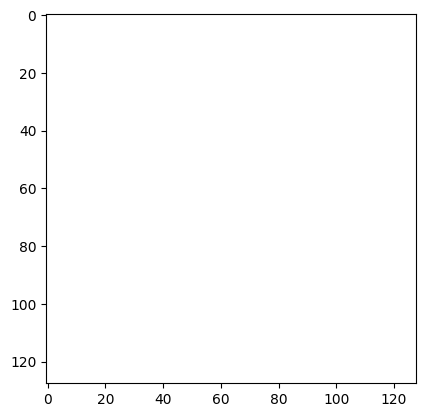

In [39]:
i = np.random.randint(0, x_train_n.shape[0])
plt.imshow(x_train_n[i]) #nans are blank; they could be land or clouds

In [40]:
dates_train_n = np.load('/content/dates_train_night.npy')
dates_val_n = np.load('/content/dates_val_night.npy')
dates_test_n = np.load('/content/dates_test_night.npy')

print(dates_train_n.shape) # from 2002-07-04 to 2018-07-04
print(dates_val_n.shape)   # from 2018-07-04 to 2021-07-04
print(dates_test_n.shape)  # from 2021-07-04 to 2023-12-31

(5832,)
(1090,)
(895,)


We know the part of the territory corresponding to land.
In the land-sea mask, 1 is for sea, and 0 for land.

(128, 128)
sea percentage =  0.408203125


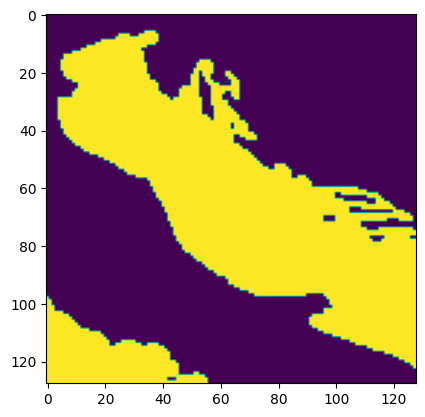

In [41]:
land_sea_mask = np.load('/content/land_sea_mask.npy')
print(land_sea_mask.shape)
plt.imshow(land_sea_mask)
total_sea = np.sum(land_sea_mask)
print("sea percentage = ", total_sea/(128*128))

Available a statistical baseline which gives good approximation.

In [42]:
baseline = np.load('/content/stat_baseline.npy')
print(baseline.shape)
print(f"min baseline temperature: {np.nanmin(baseline)}")
print(f"max baseline temperature: {np.nanmax(baseline)}")

(366, 128, 128)
min baseline temperature: 0.0
max baseline temperature: 27.10306060332889


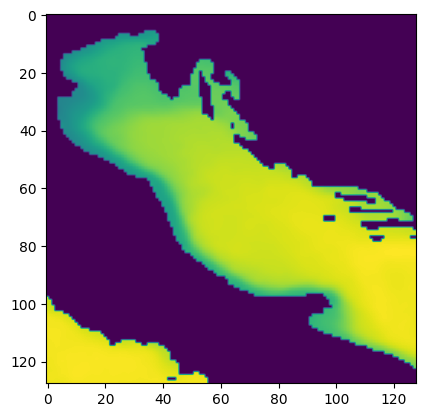

In [43]:
i = np.random.randint(0, baseline.shape[0])
plt.imshow(baseline[i]) #nans are blank; they could be land or clouds

# Gaussian Normalization on Data


In [44]:
x_train_mean = np.nanmean(x_train_n)
x_train_std = np.nanstd(x_train_n)

In [45]:
x_train_n = (x_train_n - x_train_mean) / x_train_std
x_val_n = (x_val_n - x_train_mean) / x_train_std
x_test_n = (x_test_n - x_train_mean) / x_train_std

baseline_nan = np.where(land_sea_mask,baseline,np.nan)
baseline_nan = (baseline_nan - x_train_mean) / x_train_std
baseline = np.where(land_sea_mask,baseline_nan,0.0)

# Generator

A problem with occluded data is that we do not have ground truth available, as we do not know the actual sea temperature beneath the clouds.

To address this, we create an artificial ground truth by extending the clouded region. Specifically, we superimpose the clouds from a randomly chosen different day onto a given day, providing a configurable amount of auxiliary clouds.

In [46]:
def generator(batch_size, dataset, dates):
    size = 128
    while True:
        batch_x = np.zeros((batch_size, size, size, 4))
        batch_y = np.zeros((batch_size, size, size, 3))

        for b in range(batch_size):
            # Choose an image with a sufficiently large area of visible sea
            found = False
            while not found:
              i = np.random.randint(0, dataset.shape[0])
              visible = np.sum(~np.isnan(dataset[i])/total_sea)
              if visible > 0.4:
                found = True
            image_current = np.nan_to_num(dataset[i], nan=0)
            mask_current = np.isnan(dataset[i])

            # Extending clouds

            found = False
            while not found:
              r = np.random.randint(0, dataset.shape[0])
              mask_r = np.isnan(dataset[r])
              mask_or_r = np.logical_or(mask_current, mask_r)
              nnans = np.sum(~mask_or_r)/total_sea
              if nnans > 0.05 and nnans < min(visible-.1,0.4):
                found = True

            artificial_mask_current = ~mask_or_r  #1 visible, 0 masked

            # Apply the enlarged mask to the current day's image
            image_masked_current = np.where(artificial_mask_current, image_current, 0)

            # we tune the statistical baseline according to the average sea temperature of the current day

            # convert the current date to a datetime object using pandas
            date_series = pd.to_datetime(dates[i], unit='D', origin='unix')
            day_of_year = date_series.dayofyear

            #avg temp of the current day
            image_masked_nan = np.where(artificial_mask_current, image_current, np.nan)

            avg_temp_real = np.nanmean(image_masked_nan)
            avg_temp_baseline = np.nanmean(np.where(artificial_mask_current,baseline[day_of_year - 1],np.nan))
            tuned_baseline = baseline[day_of_year - 1] + avg_temp_real - avg_temp_baseline  # Adjust the baseline to match the average temperature of the current day
            tuned_baseline = np.where(land_sea_mask,tuned_baseline,.0)


            # Removing nans for usage in neural networks

            mask_current = np.logical_not(mask_current) # 1 for clear sea, 0 for land/clouds
            diff_mask = np.logical_and(~artificial_mask_current,mask_current) # 1 for clear sea, 0 for land/clouds and artificial clo

            # Create batch_x and batch_y
            batch_x[b, ..., 0] = image_masked_current            #current artificially clouded image
            batch_x[b, ..., 1] = artificial_mask_current         #current artificial mask
            batch_x[b, ..., 2] = land_sea_mask                   #land-sea mask
            batch_x[b, ..., 3] = tuned_baseline                  #tuned baseline

            batch_y[b, ..., 0] = image_current                   #real image
            batch_y[b, ..., 1] = mask_current                    #real mask
            batch_y[b, ..., 2] = diff_mask                       #artificial mask used for the input

        yield batch_x, batch_y

In [47]:
batch_size = 32

train_gen = generator(batch_size, x_train_n, dates_train_n)
val_gen = generator(batch_size, x_val_n, dates_val_n)
test_gen = generator(batch_size, x_test_n, dates_test_n)

The generator returns two sets of data, called batch_x and batch_y. The idea is that batch_x data are possible inputs for the neural network, while batch_y data provide ground_truth information that can be used for defining the loss function, or auxiliary metrics. Let us inspect them in more detail.

In [48]:
import matplotlib.pyplot as plt

def plot_elements(images, titles):

  num_of_images = len(images)
  rows = 1
  cols = num_of_images
  mini = np.nanmin(np.array(images))
  maxi = np.nanmax(np.array(images))
  print(mini,maxi)

  plt.figure(figsize=(10, 10*num_of_images))
  for i in range(num_of_images):
    print(f"image {i}; {np.min(images[i])}, {np.max(images[i])}")
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i],vmin=mini,vmax=maxi)
    plt.axis('off')
    plt.title(titles[i])
  plt.show()

0.0 25.260000197372676
image 0; 0.0, 25.260000197372676
image 1; 0.0, 24.22500032191917
image 2; 0.0, 25.011110166456376


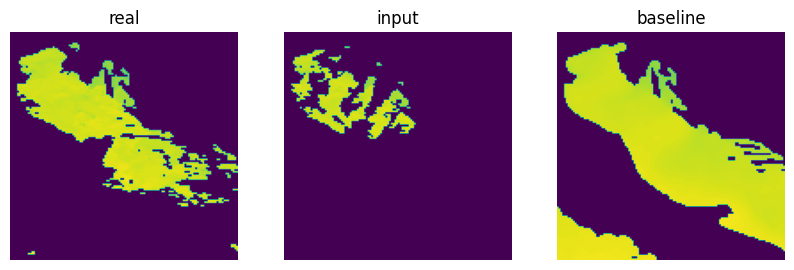

0.0 1.0
image 0; 0.0, 1.0
image 1; 0.0, 1.0
image 2; 0.0, 1.0


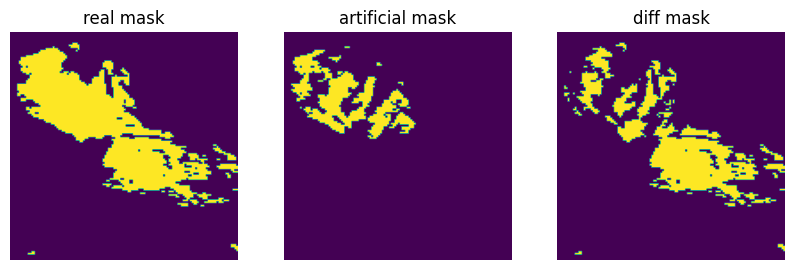

In [49]:
batch_x, batch_y = next(test_gen)
assert(np.sum(np.isnan(batch_x))==0)
assert(np.sum(np.isnan(batch_y))==0)
real_denorm = np.where(batch_y[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
artificial_denorm = np.where(batch_x[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
baseline_denorm = np.where(land_sea_mask,batch_x[0,...,3]*x_train_std + x_train_mean,0.0)
plot_elements([real_denorm, artificial_denorm, baseline_denorm], ['real', 'input','baseline'])
plot_elements([batch_y[0,...,1], batch_x[0,...,1], batch_y[0,...,2]],["real mask","artificial mask","diff mask"])


In the first row, we see:
- the real image of the day
- the input passed to the model, that is a masked version of the previous image
- the tentative reconstruction done via the statistical baseline
All images have been denormalized.

In the second row we see:
- the mask of the current day
- the enlarged masked with addiitonal clouds
- the difference, showing the portion of the image visible in the first one, but occluded in the second. This is the region where the performance of the model must be evaluated


## Loss Function (MAE)

In [50]:
def loss_func(y_true, y_pred):

    ground_truth = tf.expand_dims(y_true[..., 0], axis=-1)
    mask = tf.expand_dims(y_true[..., 2], axis=-1)
    diff = tf.abs(y_pred - ground_truth)
    weighted_diff = diff * mask
    return tf.reduce_mean(weighted_diff)

In [51]:
# Blocks without Batch Normalization and Dropout
def bottleneck_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    return x

def decoder_block(input_tensor, skip_tensor, num_filters):
    x = layers.Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(input_tensor)
    x = layers.Concatenate()([x, skip_tensor])
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

# Blocks without Dropout
def encoder_block_batch(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def bottleneck_block_batch(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

def decoder_block_batch(input_tensor, skip_tensor, num_filters):
    x = layers.Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(input_tensor)
    x = layers.Concatenate()([x, skip_tensor])
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

# Blocks with Batch Normalization (but bottleneck) and Dropout
def encoder_block_batch_dropout(input_tensor, num_filters, dropout_rate):
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)  
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def bottleneck_block_dropout(input_tensor, num_filters, dropout_rate):
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)  
    return x

def decoder_block_batch_dropout(input_tensor, skip_tensor, num_filters, dropout_rate):
    x = layers.Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(input_tensor)
    x = layers.Concatenate()([x, skip_tensor])
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)  
    return x

In [52]:
# Build U-Net with one additional encoding and decoding layer
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

     # Encoder
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block_batch(p2, 256)
    c4, p4 = encoder_block(p3, 512)
    c5, p5 = encoder_block_batch(p4, 1024)

    # Bottleneck
    bn = bottleneck_block_dropout(p5, 2048, 0.2)

    # Decoder
    u5 = decoder_block_batch(bn, c5, 1024)
    u4 = decoder_block(u5, c4, 512)
    u3 = decoder_block_batch(u4, c3, 256)
    u2 = decoder_block(u3, c2, 128)
    u1 = decoder_block(u2, c1, 64)

    # Output layer (The target is a single-channel map)
    outputs = layers.Conv2D(1, (1, 1), activation='linear', padding='same')(u1)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0002), loss=loss_func)

    return model

In [53]:
model = build_unet(input_shape=(128,128,4))
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.4, min_lr=1e-6, mode='min', min_delta=1e-4)

early_stopping = EarlyStopping(verbose=1, monitor='val_loss', patience=10, restore_best_weights=True)

result = model.fit(
    train_gen,  
    steps_per_epoch=182, # Cardinality of training set / batch size
    epochs=60, 
    validation_data=val_gen,  
    validation_steps=35,  # Cardinality of validation set / batch size
    callbacks=[reduce_lr, early_stopping]  
)

Epoch 1/60
182/182 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - loss: 0.0474 - val_loss: 0.0279 - learning_rate: 2.0000e-04
Epoch 2/60
182/182 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 0.0225 - val_loss: 0.0225 - learning_rate: 2.0000e-04
Epoch 3/60
182/182 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 0.0222 - val_loss: 0.0207 - learning_rate: 2.0000e-04
Epoch 4/60
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - loss: 0.0211 - val_loss: 0.0244 - learning_rate: 2.0000e-04
Epoch 5/60
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - loss: 0.0203 - val_loss: 0.0190 - learning_rate: 2.0000e-04
Epoch 6/60
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - loss: 0.0195 - val_loss: 0.0215 - learning_rate: 2.0000e-04
Epoch 7/60
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - loss: 0.0188 - val_loss: 0.0174 - learning_rate: 2.0000e-04
Epoch 8/60
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - loss: 0.0181 - val_loss: 0.0260 - learning_rate: 2.0000e-04
Epoch 9/60
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - loss: 0.0173 - v

## Loss Comparison
The Validation Loss is almost always higher then the Training Loss, yet it is very close thanks to dropout that allows to minimize overfitting. 

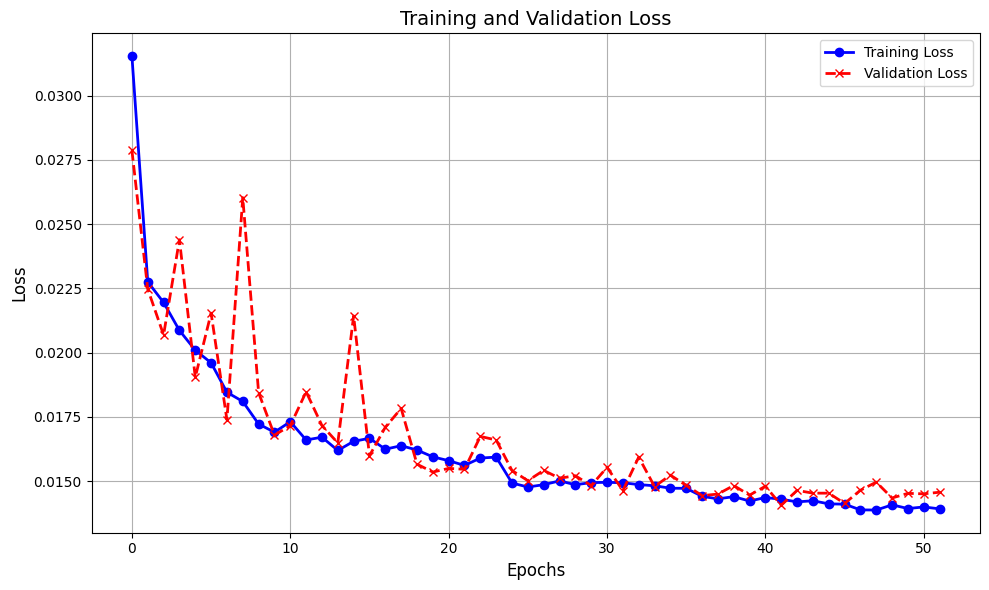

In [54]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(result.history['loss'], label='Training Loss', color='blue', linestyle='-', marker='o', markersize=6, linewidth=2)
plt.plot(result.history['val_loss'], label='Validation Loss', color='red', linestyle='--', marker='x', markersize=6, linewidth=2)

# Add titles and labels
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to fit labels and titles

# Show plot
plt.show()


# Evaluation

The model must be evaluted by means of the following function, calling the test generator 50 times. The metrics adopted is the Rooted Mean Squared Error (RMSE).

To make a running example, we measure the performance of the statistical
baseline.

In [65]:
# Initialize lists to store the errors and the maximum errors
RMSE = []
RMSE_baseline = []
# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    # My model predictions
    predictions = model.predict(batch_x, verbose=0)
    predictions_baseline = batch_x[...,3]
    # Denormalize data !!!
    predictions_baseline_denorm = predictions_baseline*x_train_std + x_train_mean
    predictions_denorm = predictions*x_train_std + x_train_mean
    predictions_denorm = np.squeeze(predictions_denorm, axis=-1)
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]

    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    dif_errors_batch_baseline = np.where(diffMask, np.abs(predictions_baseline_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    squared_errors_baseline = np.nanmean(dif_errors_batch_baseline**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))
    RMSE_baseline.append(np.sqrt(squared_errors_baseline))
RMSE = np.concatenate(RMSE)
RMSE_baseline = np.concatenate(RMSE_baseline)

print(f"RMSE Unet:", np.mean(RMSE))
print(f"RMSE Unet std :", np.std(RMSE))
print(f"RMSE Baseline:", np.mean(RMSE_baseline))
print(f"RMSE Baseline std :", np.std(RMSE_baseline))

RMSE Unet: 0.4464600542708729
RMSE Unet std : 0.13662728000090388
RMSE Baseline: 0.6267025240718284
RMSE Baseline std : 0.18268252067155882


## Model Summary

In [58]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 128, 128, 64)   │          2,368 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 64)     │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 128)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 32, 32, 256)    │          1,024 │ conv2d_27[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 32, 32, 256)    │          1,024 │ conv2d_28[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 256)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 8, 8, 512)      │              0 │ conv2d_30[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_8[0][0]  │
├──────────────────────

 Total params: 415,047,685 (1.55 GB)

 Trainable params: 138,344,449 (527.74 MB)

 Non-trainable params: 14,336 (56.00 KB)

 Optimizer params: 276,688,900 (1.03 GB)

In [60]:
#from google.colab import drive
#drive.mount('/content/drive')
#model.save_weights('/content/drive/MyDrive/u_net.weights.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Comments

Over the course of my project, I explored several approaches to achieve the best performance for our task. Initially, I experimented with Generative Adversarial Networks (GANs). Implementing GANs proved to be challenging due to the complex balance required between the generator and discriminator. This balance is crucial for the effective training of GANs, and managing it presented significant difficulties.

Despite the effort put into fine-tuning the GAN architecture, the results were not as satisfactory as expected. The training process was intricate and required constant adjustments to maintain equilibrium between the generator and discriminator, which often led to suboptimal performance.

Afterward, I shifted focus to the U-Net architecture, which is well-regarded for tasks involving image segmentation. The U-Net model provided a more straightforward and effective solution compared to the GAN. It offered better results in terms of RMSE and reliability for our specific application. The U-Net's architecture, with its encoder-decoder structure proved to be the most efficient for this task.